In [55]:
### Packages ###

# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import io

# Machine Learning


In [68]:
# VOC levels
voc_url_18 = 'https://wwwn.cdc.gov//Nchs/Nhanes/2017-2018/P_VOCWB.XPT'
voc_url_16 = 'https://wwwn.cdc.gov//Nchs/Nhanes/2015-2016/VOCWB_I.XPT'
voc_url_14 = 'https://wwwn.cdc.gov//Nchs/Nhanes/2013-2014/VOCWB_H.XPT'
voc_url_12 = 'https://wwwn.cdc.gov//Nchs/Nhanes/2011-2012/VOCWB_G.XPT'
voc_url_10 = 'https://wwwn.cdc.gov//Nchs/Nhanes/2009-2010/VOCWB_F.XPT'
voc_url_8  = 'https://wwwn.cdc.gov//Nchs/Nhanes/2007-2008/VOCWB_E.XPT'
voc_url_6  = 'https://wwwn.cdc.gov//Nchs/Nhanes/2005-2006/VOCWB_D.XPT'
voc_url_4  = 'https://wwwn.cdc.gov//Nchs/Nhanes/2003-2004/L04VOC_C.XPT'
voc_url_2  = 'https://wwwn.cdc.gov//Nchs/Nhanes/2001-2002/L04VOC_B.XPT'
voc_url_0  = 'https://wwwn.cdc.gov//Nchs/Nhanes/1999-2000/LAB04.XPT'


# Paint/cleaning products 
tox_url_18 = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/VTQ_J.XPT'
tox_url_16 = 'https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/VTQ_I.XPT'
tox_url_14 = 'https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/VTQ_H.XPT'
tox_url_12 = 'https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/VTQ_G.XPT'
tox_url_10 = 'https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/VTQ_F.XPT'
### There is no VTQ data before 2010 ###

# lists to store all urls we will work with
tox_urls = [tox_url_10, tox_url_12, tox_url_14, tox_url_16, tox_url_18]
voc_urls = [voc_url_10, voc_url_12, voc_url_14, voc_url_16, voc_url_18]

In [69]:
def read_sas_url(url):
    """
    This function reads SAS .xpt files 
    from the NHANES wesbite urls and  
    converts them into pandas data frames.
    """
    r = requests.get(url)
    return pd.read_sas(io.BytesIO(r.content), format= 'xport')

In [70]:
def append_match(datasets, keep_cols):
    """ 
    This function takes a list of datasets and concats
    them while matching the column names. 
    """

    if not datasets or len(datasets) == 0:
        return None

    # Reove columns not in list for each data set
    filtered_datasets = [df[keep_cols] for df in datasets]

    # Extract common col names
    common_cols = filtered_datasets[0].columns

    # Check if all datasets have same cols
    for df in filtered_datasets[1:]:
        common_cols = common_cols.intersection(df.columns)

    # Concat all the datasets if assumptions are met
    append_df = pd.concat([df[common_cols] for df in filtered_datasets], ignore_index=True)

    return append_df

In [71]:
###READ IN ALL THE DATA###
df_tox_18 = read_sas_url(tox_url_18)
df_tox_16 = read_sas_url(tox_url_16)
df_tox_14 = read_sas_url(tox_url_14)
df_tox_12 = read_sas_url(tox_url_12)
df_tox_10 = read_sas_url(tox_url_10)

df_voc_18 = read_sas_url(voc_url_18)
df_voc_16 = read_sas_url(voc_url_16)
df_voc_14 = read_sas_url(voc_url_14)
df_voc_12 = read_sas_url(voc_url_12)
df_voc_10 = read_sas_url(voc_url_10)

In [72]:
# List of variables we'll use
tox_cols = ['SEQN', 'VTQ200A', 'VTQ231A']
# List of datasets we'll use
tox_list = [df_tox_18, df_tox_16, df_tox_14]

# Run function to concat all the datasets
df_tox_all = append_match(tox_list, tox_cols)

In [73]:
voc_cols = ['SEQN', 'LBXVBZ', 'LBXVEB','LBXVXY',]
voc_list = [df_voc_18, df_voc_16, df_voc_14]

df_voc_all = append_match(voc_list, voc_cols)

In [39]:
pd.DataFrame(df_tox_all.isnull().sum().sort_values(ascending=False)).head(40)

,0
VTQ231A,1259
VTQ200A,1255
SEQN,0


In [42]:
pd.DataFrame(df_voc_all.isnull().sum().sort_values(ascending=False)).head(40)

,0
LBXVBZ,1376
LBXVBZ,1376
LBXVEB,1345
LBXVXY,1238
SEQN,0


In [74]:
# Drop rows with NA values
df_voc_all = df_voc_all.dropna()
df_tox_all = df_tox_all.dropna()

Since we are only interested in the survey data where persons give answers "yes" or "no," then we need to only keep cell values that are either 1 or 2.

In [75]:
df_tox_all['VTQ200A'].unique()

array([1., 2., 9., 7.])

In [76]:
df_tox_all['VTQ231A'].unique()

array([2., 1., 9.])

In [77]:
df_tox_all = df_tox_all[(df_tox_all['VTQ200A'].isin([1,2])) & (df_tox_all['VTQ231A'].isin([1,2]))]

In [78]:
df_combined = pd.merge(df_tox_all, df_voc_all, on='SEQN', how='inner')
df_combined.head()

,SEQN,VTQ200A,VTQ231A,LBXVBZ,LBXVEB,LBXVXY
0,83732.0,2.0,2.0,0.039,0.017,0.024
1,83734.0,1.0,2.0,0.017,0.017,0.072
2,83741.0,2.0,2.0,0.017,0.032,0.081
3,83742.0,2.0,2.0,0.045,0.017,0.024
4,83744.0,2.0,2.0,0.034,0.017,0.048


In [79]:
# Log-transform the last four columns
df_combined.iloc[:, -4:] = np.log(df_combined.iloc[:, -4:])

### Potential varibales of interest (VOCs)

- `LBXVBZ`: Blood Benzene (ng/mL)
- `LBXVEB`: Blood Ethylbenzene (ng/L)
- `LBXVXY`: Blood m-/p-Xylene (ng/L)

### Potential variables of interest (toxins)

- `VTQ200A`: Store paints of fuels inside home?
- `VTD261B`: Long since use dry cleaning products? **Consider throwing this one out - lots of missing data.** 
- `VTQ231A`: Use moth balls or toilet deodorizers?

## Exploratory Data Analysis

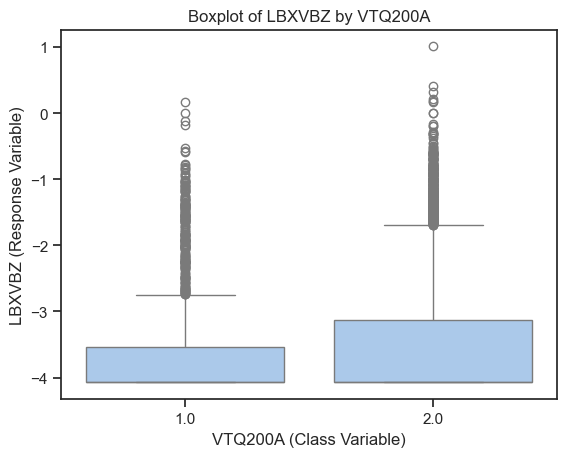

In [84]:
# Create boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=df_combined, x='VTQ200A', y='LBXVBZ')

# Adding labels and title
plt.xlabel('VTQ200A (Class Variable)')
plt.ylabel('LBXVBZ (Response Variable)')
plt.title('Boxplot of LBXVBZ by VTQ200A')

# Show plot
plt.show()

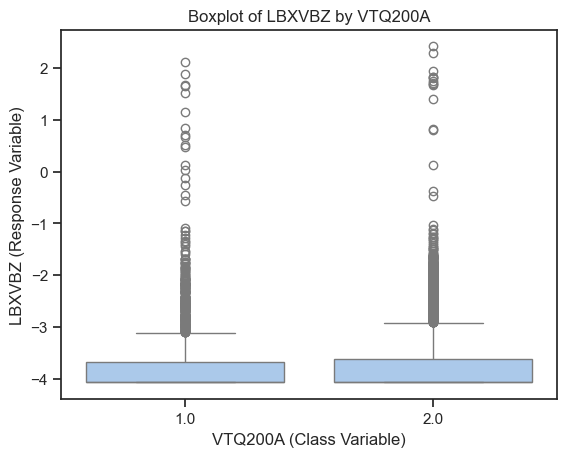

In [85]:
# Create boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=df_combined, x='VTQ200A', y='LBXVEB')

# Adding labels and title
plt.xlabel('VTQ200A (Class Variable)')
plt.ylabel('LBXVBZ (Response Variable)')
plt.title('Boxplot of LBXVBZ by VTQ200A')

# Show plot
plt.show()

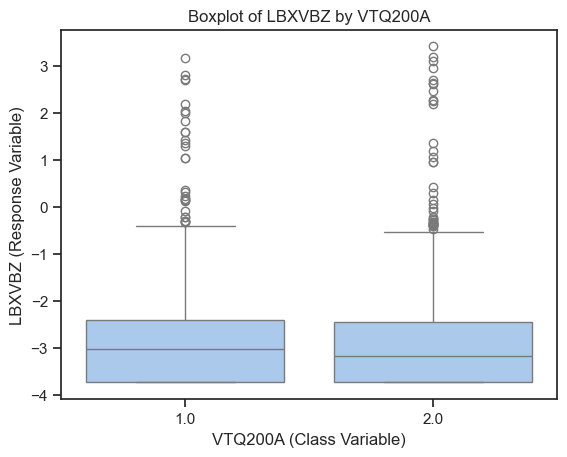

In [86]:
# Create boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=df_combined, x='VTQ200A', y='LBXVXY')

# Adding labels and title
plt.xlabel('VTQ200A (Class Variable)')
plt.ylabel('LBXVBZ (Response Variable)')
plt.title('Boxplot of LBXVBZ by VTQ200A')

# Show plot
plt.show()

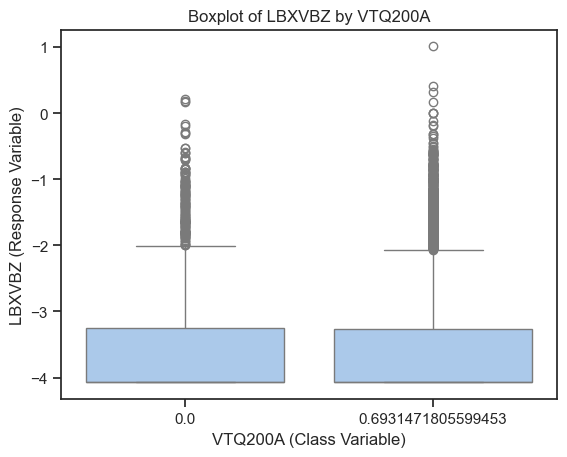

In [90]:
# Create boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=df_combined, x='VTQ231A', y='LBXVBZ')

# Adding labels and title
plt.xlabel('VTQ200A (Class Variable)')
plt.ylabel('LBXVBZ (Response Variable)')
plt.title('Boxplot of LBXVBZ by VTQ200A')

# Show plot
plt.show()

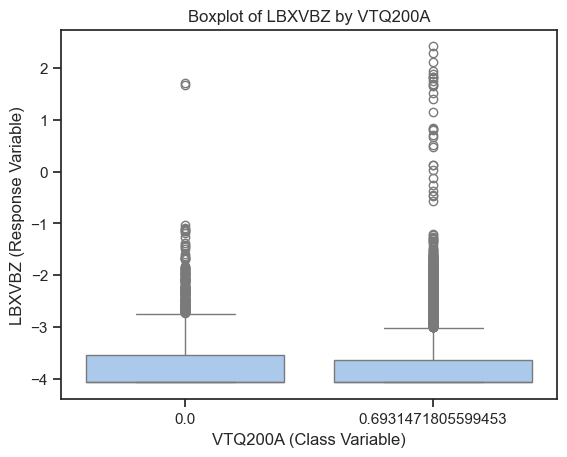

In [91]:
# Create boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=df_combined, x='VTQ231A', y='LBXVEB')

# Adding labels and title
plt.xlabel('VTQ200A (Class Variable)')
plt.ylabel('LBXVBZ (Response Variable)')
plt.title('Boxplot of LBXVBZ by VTQ200A')

# Show plot
plt.show()

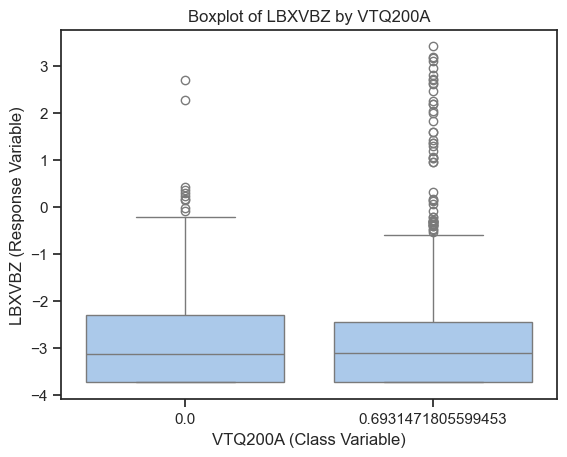

In [92]:
# Create boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=df_combined, x='VTQ231A', y='LBXVXY')

# Adding labels and title
plt.xlabel('VTQ200A (Class Variable)')
plt.ylabel('LBXVBZ (Response Variable)')
plt.title('Boxplot of LBXVBZ by VTQ200A')

# Show plot
plt.show()

## Preprocessing

## Models

## Discussion